In [ ]:
import torch.optim as optim
import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm import tqdm

device = xm.xla_device()  # TPU device


/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
import zipfile

# Unzip file
with zipfile.ZipFile('/content/drive/MyDrive/pdf_json.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extract')


### 1.Use the COVID-19 corpus
Extract all the abstracts from the COVID-19 text files and use them as the corpus. Ensure that you create
a vocabulary of around 10,000 words.

In [ ]:
%%time
'''extracting abstract from the json'''
import os
import json
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool

# Function to convert JSON to text
def json2text(filename):
    with open(filename, 'r') as file:
        paper_content = json.load(file)

    abstract = ""
    # Get the abstract
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract += abs['text']

    return (f'{abstract}').lower()

# Function to write converted text to file
def write_file(filename):
    # Convert JSON to text
    content = json2text(filename)

    # Define the output file path
    base_name = os.path.splitext(os.path.basename(filename))[0]
    output_dir = '/content/pdf_text'  # desired output directory
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    output_file = os.path.join(output_dir, f'{base_name}.txt')

    # Writing the content to a .txt file
    with open(output_file, 'w') as file:
        file.write(content)

# Function for parallel processing
def par_write(files):
    """
    Read a chunk of files and let the cores of your machine
    do the job of format conversion in parallel
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(write_file, files, chunksize=16)
    p.close()

# Directory path for JSON files
dir_path = '/content/extract/pdf_json'

# List all JSON files in the directory
json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.json')]

# Process the files in parallel
par_write(json_files)


CPU times: user 1.36 s, sys: 816 ms, total: 2.17 s
Wall time: 4.42 s


In [ ]:
# Delete the folder and its contents using shell command
!rm -rf /content/extract

In [ ]:
def remove_urls(text):
  '''removes all urls and email ids using regular expression'''

  url_pattern = r'https?://\S+|www\.\S+'
  email_id_pattern=r"\S*@\S*\s?"
  clean_text=re.sub(url_pattern, '', text)
  clean_text=re.sub(email_id_pattern, '', clean_text)

  return clean_text

def remove_single_letters(text):
  '''removes all single letters except a '''
  single_letters= r'\b[b-zB-Z]\b'
  cleaned_text = re.sub(single_letters, '', text)
  return cleaned_text

def remove_brackets(text):
    '''Removes text inside brackets '''
    return re.sub(r'\(.*?\)', '', text)

def remove_num_spl_char(text):
  '''removes all numeric and special characters'''
  corpus_num=re.sub(r'\d+', '', text)
  return re.sub('[^\w\s]', '', corpus_num)

def remove_whitespace(text):
  '''it removes all extra whitespace'''
  return " ".join(text.split())

In [ ]:
%%time
import os
import re
from multiprocessing import Pool

def preprocess(text):

    rem_urls=remove_urls(text)
    rem_bracket_ct=remove_brackets(rem_urls)
    rem_num_spl_char=remove_num_spl_char(rem_bracket_ct)
    rem_singlechar=remove_single_letters(rem_num_spl_char)
    cleaned_text=remove_whitespace(rem_singlechar)

    return cleaned_text

def preprocess_file(filename):
    """
    Read the content of a file, preprocess it, and save the cleaned text back to the file.
    """
    with open(filename, 'r') as file:
        text = file.read()
          # Preprocess text
    content = preprocess(text)

    with open(filename, 'w') as file:
        file.write(content)

def par_write(files):
    """
    Process a list of files in parallel and save the cleaned text back to the files.
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(preprocess_file, files, chunksize=50)
    p.close()

# Example usage
dir_path = '/content/pdf_text'
txt_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
par_write(txt_files)


CPU times: user 697 ms, sys: 17.6 s, total: 18.3 s
Wall time: 19 s


In [ ]:

from tqdm import tqdm
'''saving the final corpus in my drive by concat. all preprocessed .txt file'''

dir = "/content/Abstract_corpus.txt"  # Specify the output file path

# Open the output file in write mode
with open(dir, 'a') as output_file:
    for file_path in tqdm(txt_files, desc="Reading files"):
        try:
            with open(file_path, 'r') as f:
                content = f.read()
                output_file.write(content)  # Write the content of each file to the output file
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")


Reading files: 100%|██████████| 56528/56528 [00:01<00:00, 36567.81it/s]


In [ ]:
with open('/content/Abstract_corpus.txt','r') as f:
  corpus=f.read()

In [ ]:

import nltk
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

def build_vocabulary(corpus, vocab_size=10000):
    """
    Build a vocabulary of the most common words in the corpus.
    """
    # Tokenize the corpus using NLTK
    words = nltk.word_tokenize(corpus.lower())

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Count word frequencies and select the most common words
    most_common_words = Counter(words).most_common(vocab_size)

    # Create a vocabulary where words map to their index
    vocabulary = {word: idx for idx, (word, _) in enumerate(most_common_words)}
    return vocabulary

vocabulary = build_vocabulary(corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Construct One-Hot Vectors (OHVs)

In [ ]:
import numpy as np

def one_hot_vector(word, vocab):
  '''creates a one hot vector for a given word'''
    vec = np.zeros(len(vocab))
    if word in vocab:
        idx = vocab[word]
        vec[idx] = 1
    return vec

## Architecture Description

**SkipGram Model with Negative Sampling**

The implemented architecture is a SkipGram model designed to learn word embeddings by predicting the context words of a given target word, using negative sampling to efficiently train on large vocabularies.

1. **Model Components**

**Input Layer**

Accepts the indices of the target word, context word, and negative samples, which are each represented by unique IDs from the vocabulary.

**Embedding Layers**

in_embedding: Maps the target word indices to dense vector representations (Win).

out_embedding: Maps context and negative word indices to dense vector representations (Wout).

Each embedding layer has dimensions of (vocab_size, embedding_dim).

**Output**

Computes similarity scores between the target-context pair and target-negative pairs.

2. **Forward Pass**

**Positive Score**

The model calculates a dot product between Win(target_word) and Wout(context_word) to obtain a similarity score for the true target-context pair. A loss is computed using the sigmoid activation followed by negative log-likelihood.

**Negative Score**

The model calculates the dot products between the target word embedding and embeddings of negative samples, Wout(negative_samples), and applies a loss function to penalize similarity with incorrect context words.

3.**Loss Function**

Combines positive loss (to encourage high similarity for true context words) and negative loss (to discourage similarity with negative samples), maximizing the difference between correct and incorrect predictions.

4. **Training Loop**

  1. **Optimizer**: Stochastic Gradient Descent (SGD) with a learning rate of 0.05.

  2. **Batching**: Training data is processed in batches of size 250, stored in a PyTorch DataLoader for efficient mini-batch training.

  3. **Epochs**: Model is trained for a total of 29 epochs.


### Generate Training Pairs


In [ ]:
'''stores vocabulary words as index to word format'''
inverse_vocab = {index: token for token, index in vocabulary.items()}

In [ ]:
def create_vocabulary_corpus(corpus_file, vocabulary):
  """Creates a new corpus containing only words from the vocabulary."""

  with open(corpus_file, 'r') as f:
    corpus = f.read()

  new_corpus = ""
  for word in nltk.word_tokenize(corpus.lower()):
    if word in vocabulary:
      new_corpus += word + " "

  return new_corpus

new_corpus = create_vocabulary_corpus('/content/Abstract_corpus.txt', vocabulary)



In [ ]:
corpus[:100]

'our study aimed to investigate the factors affecting the prognosis of patients with mental disorders'

In [ ]:
new_corpus[:100]

'study aimed investigate factors affecting prognosis patients mental disorders covid patients mental '

In [ ]:
new_corpus=new_corpus.split()

In [ ]:
context_window = 2
'''creates the training pairs'''
training_pairs = []
for i, target_word in enumerate(new_corpus):
    # Get the context words within the window
    start = max(0, i - context_window)
    end = min(len(new_corpus), i + context_window + 1)

    context_words = [new_corpus[j] for j in range(start, end) if j != i]

    # Add the (target, context) pairs
    for context_word in context_words:
        training_pairs.append((target_word, context_word))


In [ ]:
!pip install torch_xla

### Generated Negative Samples

In [ ]:
'''
This script generates negative samples for training a SkipGram model with negative sampling.

1. **Batch Processing:** Divide the training pairs into manageable batches for efficiency.
2. **Negative Sampling:** For each target-context pair in a batch, generate `num_negative_samples` random words from the vocabulary, excluding the target and context words.
3. **Filtering and Completion:** Ensure exactly 5 valid negative samples per pair by filtering out duplicates and sampling additional words if needed.
4. **Output:** Store tuples of (target, context, negative_samples) in `final_training_data` for model training.
'''

import numpy as np
from tqdm import tqdm

num_negative_samples = 5
batch_size = 1000


vocab_array = np.array(list(vocabulary.values()))
vocab_size = len(vocabulary)

temp_training_data = []


for batch_start in tqdm(range(0, len(training_pairs), batch_size), desc="Generating negative samples"):
    batch_pairs = training_pairs[batch_start:batch_start + batch_size]


    negative_samples_batch = np.random.choice(vocab_array, size=(len(batch_pairs), num_negative_samples), replace=True)

    # Store target, context, and negative sample indices temporarily
    for (target, context), neg_samples_indices in zip(batch_pairs, negative_samples_batch):
        # Filter out the context word index from the negative samples
        filtered_neg_samples = [idx for idx in neg_samples_indices if idx != vocabulary[context] and idx != vocabulary[target]]

        # If there are fewer than 5 negative samples, sample more to ensure we have 5
        if len(filtered_neg_samples) < num_negative_samples:
            # We already filtered out the context and target word, now we need to fill up to 5 samples
            # Sample additional negatives, excluding context and target indices
            remaining_vocab = np.setdiff1d(vocab_array, [vocabulary[target], vocabulary[context]])
            additional_negatives = np.random.choice(remaining_vocab, size=num_negative_samples - len(filtered_neg_samples), replace=True)
            filtered_neg_samples.extend(additional_negatives)


        filtered_neg_samples = filtered_neg_samples[:num_negative_samples]


        temp_training_data.append((vocabulary[target], vocabulary[context], filtered_neg_samples))


final_training_data = temp_training_data


print(final_training_data[:5])

# Check if all entries now have 5 negative samples
for idx, (target_idx, context_idx, negative_indices) in enumerate(final_training_data):
    if len(negative_indices) < 5:
        print(f"Warning: Entry {idx} still has fewer than 5 negative samples.")


Generating negative samples: 100%|██████████| 17763/17763 [01:37<00:00, 181.40it/s]


[(4, 511, [3606, 1565, 1403, 2740, 818]), (4, 424, [9714, 439, 1633, 532, 1475]), (511, 4, [8389, 6783, 9066, 1569, 5315]), (511, 424, [8873, 4291, 3477, 4554, 6266]), (511, 59, [5553, 3174, 7108, 1422, 8136])]


### Batch Data
The provided code creates a PyTorch DataLoader to efficiently batch and shuffle training data for the SkipGram model.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

targets, contexts, negatives = zip(*final_training_data)

targets_tensor = torch.tensor(targets, dtype=torch.long)
contexts_tensor = torch.tensor(contexts, dtype=torch.long)
negatives_tensor = torch.tensor(negatives, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
dataset = TensorDataset(targets_tensor, contexts_tensor, negatives_tensor)
batch_size = 250  # Adjust batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### SkipGramModel using Negative Sampling

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.out_embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target_word, context_word, negative_samples):
        target_embedding = self.in_embedding(target_word)  # (batch_size, embedding_dim)
        context_embedding = self.out_embedding(context_word)  # (batch_size, embedding_dim)
        neg_samples_embedding = self.out_embedding(negative_samples)  # (batch_size, num_neg_samples, embedding_dim)

        # Positive score
        pos_score = torch.mul(target_embedding, context_embedding).sum(dim=1)
        pos_loss = torch.log(torch.sigmoid(pos_score)).mean()

        # Negative score
        neg_score = torch.bmm(neg_samples_embedding, target_embedding.unsqueeze(2)).squeeze()
        neg_loss = torch.log(torch.sigmoid(-neg_score)).mean()

        return - (pos_loss + neg_loss)  # Negative log likelihood loss


### Training

In [ ]:
# Hyperparameters
vocab_size = len(vocabulary)  # Set to the size of your vocabulary
embedding_dim = 100  # Embedding size
learning_rate = 0.05
num_epochs = 18

# Initialize model, loss, and optimizer
model = SkipGramModel(vocab_size, embedding_dim)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

epoch_loss=[]
# Training loop with tqdm progress bar
for epoch in range(num_epochs):
    total_loss = 0
    # Use tqdm for batch progress tracking
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for target_word, context_word, negative_samples in pbar:
            optimizer.zero_grad()

            # Forward pass
            loss = model(target_word, context_word, negative_samples)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update progress bar with loss information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")
    epoch_loss.append(total_loss / len(dataloader))


Epoch 1/18: 100%|██████████| 71049/71049 [07:37<00:00, 155.32it/s, loss=6.91]


Epoch 1, Loss: 6.910019588721465


Epoch 2/18: 100%|██████████| 71049/71049 [07:49<00:00, 151.44it/s, loss=5.47]


Epoch 2, Loss: 5.472267563736436


Epoch 3/18: 100%|██████████| 71049/71049 [07:38<00:00, 154.87it/s, loss=4.67]


Epoch 3, Loss: 4.670370435947607


Epoch 4/18: 100%|██████████| 71049/71049 [07:46<00:00, 152.31it/s, loss=4.13]


Epoch 4, Loss: 4.129143464872155


Epoch 5/18: 100%|██████████| 71049/71049 [07:39<00:00, 154.60it/s, loss=3.73]


Epoch 5, Loss: 3.7284655440481016


Epoch 6/18: 100%|██████████| 71049/71049 [07:39<00:00, 154.50it/s, loss=3.41]


Epoch 6, Loss: 3.4142392871364717


Epoch 7/18: 100%|██████████| 71049/71049 [07:47<00:00, 151.88it/s, loss=3.16]


Epoch 7, Loss: 3.158063875529719


Epoch 8/18: 100%|██████████| 71049/71049 [07:36<00:00, 155.58it/s, loss=2.94]


Epoch 8, Loss: 2.943664481049965


Epoch 9/18: 100%|██████████| 71049/71049 [07:40<00:00, 154.14it/s, loss=2.76]


Epoch 9, Loss: 2.7609917793229095


Epoch 10/18: 100%|██████████| 71049/71049 [07:46<00:00, 152.27it/s, loss=2.6]


Epoch 10, Loss: 2.603525369046087


Epoch 11/18: 100%|██████████| 71049/71049 [07:46<00:00, 152.30it/s, loss=2.47]


Epoch 11, Loss: 2.466770117090821


Epoch 12/18: 100%|██████████| 71049/71049 [07:38<00:00, 154.83it/s, loss=2.35]


Epoch 12, Loss: 2.347415416475154


Epoch 13/18: 100%|██████████| 71049/71049 [07:47<00:00, 152.09it/s, loss=2.24]


Epoch 13, Loss: 2.2428636023707287


Epoch 14/18: 100%|██████████| 71049/71049 [07:40<00:00, 154.18it/s, loss=2.15]


Epoch 14, Loss: 2.1509792081918686


Epoch 15/18: 100%|██████████| 71049/71049 [07:53<00:00, 150.19it/s, loss=2.07]


Epoch 15, Loss: 2.069981329568486


Epoch 16/18: 100%|██████████| 71049/71049 [07:38<00:00, 154.79it/s, loss=2]


Epoch 16, Loss: 1.9983012643067997


Epoch 17/18: 100%|██████████| 71049/71049 [07:46<00:00, 152.28it/s, loss=1.93]


Epoch 17, Loss: 1.934559297945201


Epoch 18/18: 100%|██████████| 71049/71049 [07:36<00:00, 155.76it/s, loss=1.88]

Epoch 18, Loss: 1.8775941802590626


In [ ]:
'''Due to TPU usage limitations,have saved and retrained the model'''
# Hyperparameters
vocab_size = len(vocabulary)  # Set to the size of your vocabulary
embedding_dim = 100  # Embedding size
learning_rate = 0.05
num_epochs = 15

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

epoch_loss=[]
# Training loop with tqdm progress bar
for epoch in range(num_epochs):
    total_loss = 0
    # Use tqdm for batch progress tracking
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for target_word, context_word, negative_samples in pbar:
            optimizer.zero_grad()

            # Forward pass
            loss = model(target_word, context_word, negative_samples)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update progress bar with loss information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")
    epoch_loss.append(total_loss / len(dataloader))


Epoch 1/15: 100%|██████████| 71049/71049 [07:22<00:00, 160.55it/s, loss=1.72]


Epoch 1, Loss: 1.7151104715228203


Epoch 2/15: 100%|██████████| 71049/71049 [07:43<00:00, 153.44it/s, loss=1.68]


Epoch 2, Loss: 1.6785950873305449


Epoch 3/15: 100%|██████████| 71049/71049 [07:28<00:00, 158.45it/s, loss=1.65]


Epoch 3, Loss: 1.6449908090628693


Epoch 4/15: 100%|██████████| 71049/71049 [07:42<00:00, 153.60it/s, loss=1.61]


Epoch 4, Loss: 1.613928753599248


Epoch 5/15: 100%|██████████| 71049/71049 [07:43<00:00, 153.26it/s, loss=1.59]


Epoch 5, Loss: 1.5851042181516435


Epoch 6/15: 100%|██████████| 71049/71049 [07:30<00:00, 157.70it/s, loss=1.56]


Epoch 6, Loss: 1.5582621072145328


Epoch 7/15: 100%|██████████| 71049/71049 [07:49<00:00, 151.17it/s, loss=1.53]


Epoch 7, Loss: 1.5331711142327804


Epoch 8/15: 100%|██████████| 71049/71049 [07:28<00:00, 158.42it/s, loss=1.51]


Epoch 8, Loss: 1.509668482635343


Epoch 9/15: 100%|██████████| 71049/71049 [07:55<00:00, 149.46it/s, loss=1.49]


Epoch 9, Loss: 1.487576592225079


Epoch 10/15: 100%|██████████| 71049/71049 [07:34<00:00, 156.16it/s, loss=1.47]


Epoch 10, Loss: 1.4667547595588362


Epoch 11/15: 100%|█████████▉| 70928/71049 [07:39<00:00, 154.52it/s, loss=1.45]


KeyboardInterrupt: 

### Loss vs Epoch

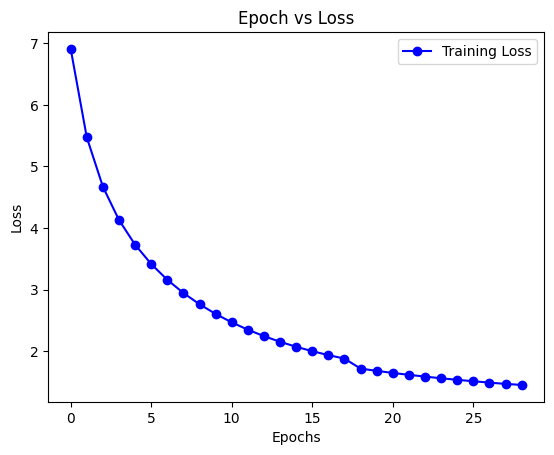

In [ ]:
plt.plot(range(29 ), epoch_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

### Saving & Loading the model

In [ ]:
#Save the model

torch.save(model.state_dict(), '/content/drive/MyDrive/skipgram_model_weights_assignment.pth')


In [ ]:
#Load the model

import pickle
import torch

# Load the training pairs
training_pairs_save_path = '/content/drive/MyDrive/training_pairs.pkl'
with open(training_pairs_save_path, 'rb') as f:
    final_training_data = pickle.load(f)

print(f"Training pairs loaded: {len(final_training_data)} pairs.")

# Load the vocabulary
vocab_save_path = '/content/drive/MyDrive/vocabulary.pkl'
with open(vocab_save_path, 'rb') as f:
    vocabulary = pickle.load(f)

print(f"Vocabulary loaded: {len(vocabulary)} words.")



vocab_size = len(vocabulary)
embedding_dim = 100

model = SkipGramModel(vocab_size, embedding_dim)

# Load the saved model weights
model_save_path = '/content/drive/MyDrive/skipgram_model_weights_assignment.pth'
model.load_state_dict(torch.load(model_save_path))
model.eval()
print("Model loaded successfully.")


### Test Analogies

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def test_analogy_cosine(model, word_a, word_b, word_c, word_to_id, top_n=5):
    """
    Perform analogy testing using cosine similarity.
    Answers the question: 'word_a is to word_b as word_c is to ?'

    Returns the top_n closest words to the analogy vector.
    """
    # Get embeddings for each word
    try:
        vec_a = model.in_embedding.weight[word_to_id[word_a]].detach().cpu().numpy().reshape(1, -1)
        vec_b = model.in_embedding.weight[word_to_id[word_b]].detach().cpu().numpy().reshape(1, -1)
        vec_c = model.in_embedding.weight[word_to_id[word_c]].detach().cpu().numpy().reshape(1, -1)
    except KeyError as e:
        print(f"Word not found in vocabulary: {e}")
        return None

    # Calculate the analogy vector: word_b - word_a + word_c
    analogy_vector = vec_b - vec_a + vec_c

    # List to store the similarity scores for words
    similarities = []

    # Iterate over vocabulary to find the most similar words, excluding original words
    for word, idx in word_to_id.items():
        if word in [word_a, word_b, word_c]:  # Exclude original words
            continue

        vec_d = model.in_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)

        # Calculate cosine similarity between analogy vector and each word vector
        similarity = cosine_similarity(analogy_vector, vec_d)[0][0]
        similarities.append((word, similarity))

    # Sort words by similarity and return top_n closest words
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_n]


word_a = 'social'
word_b = 'distancing'
word_c = 'quarantine'

top_n = 5
results = test_analogy_cosine(model, word_a, word_b, word_c, vocabulary, top_n)

if results:
    for word, similarity in results:
        print(f"'{word}' (similarity: {similarity:.4f})")
else:
    print("Analogy test failed. Ensure all words are in vocabulary.")


'diagnosis' (similarity: 0.7577)
'suggests' (similarity: 0.7533)
'worldwide' (similarity: 0.7525)
'prevention' (similarity: 0.7497)
'conclusions' (similarity: 0.7452)


## TASK 2

1.   **Find similar words for a word of your choice using Win**




In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_words_win(model, word, word_to_id, top_n=5):
    '''Finds the top-N words most similar to a given word using the `in_embedding matrix.'''

    try:
        vec = model.in_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
    except KeyError as e:
        print(f"Word not found in vocabulary: {e}")
        return None


    similarities = []


    for other_word, idx in word_to_id.items():
        if other_word == word:  # Exclude the original word
            continue

        vec_other = model.in_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)


        similarity = cosine_similarity(vec, vec_other)[0][0]
        similarities.append((other_word, similarity))


    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_n]


word = 'social'
results_win = find_similar_words_win(model, word, vocabulary, top_n=5)
if results_win:
    for word, similarity in results_win:
        print(f"'{word}' (similarity: {similarity:.4f})")
else:
    print("Word not found in vocabulary.")


'impact' (similarity: 0.9124)
'global' (similarity: 0.9101)
'community' (similarity: 0.9074)
'distancing' (similarity: 0.9072)
'measures' (similarity: 0.9065)


2.   **Find the similar words for the same word chosen in (1) using Wout**



In [ ]:
def find_similar_words_wout(model, word, word_to_id, top_n=5):
  '''Finds the top-N words most similar to a given word using the out_embedding matrix.'''

    try:
        vec = model.out_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
    except KeyError as e:
        print(f"Word not found in vocabulary: {e}")
        return None


    similarities = []


    for other_word, idx in word_to_id.items():
        if other_word == word:
            continue

        vec_other = model.out_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)


        similarity = cosine_similarity(vec, vec_other)[0][0]
        similarities.append((other_word, similarity))


    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_n]


word = 'social'
results_wout = find_similar_words_wout(model, word, vocabulary, top_n=5)
if results_wout:
    for word, similarity in results_wout:
        print(f"'{word}' (similarity: {similarity:.4f})")
else:
    print("Word not found in vocabulary.")


'health' (similarity: 0.9105)
'pandemic' (similarity: 0.8656)
'new' (similarity: 0.8637)
'study' (similarity: 0.8593)
'data' (similarity: 0.8587)


3.   **Find the similar words for the same word chosen in (1) after combining Win and Wout - either concatenate them to have a longer vector or average them out**



In [ ]:
def find_similar_words_combined_avg(model, word, word_to_id, top_n=5):
  '''Finds the top-N words most similar to a given word using the averaged embeddings from `Win` and `Wout`.'''

    try:
        vec_win = model.in_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
        vec_wout = model.out_embedding.weight[word_to_id[word]].detach().cpu().numpy().reshape(1, -1)
    except KeyError as e:
        print(f"Word not found in vocabulary: {e}")
        return None


    combined_vec = (vec_win + vec_wout) / 2


    similarities = []


    for other_word, idx in word_to_id.items():
        if other_word == word:  # Exclude the original word
            continue

        vec_win_other = model.in_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)
        vec_wout_other = model.out_embedding.weight[idx].detach().cpu().numpy().reshape(1, -1)


        combined_vec_other = (vec_win_other + vec_wout_other) / 2


        similarity = cosine_similarity(combined_vec, combined_vec_other)[0][0]
        similarities.append((other_word, similarity))


    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_n]


word='social'
results_combined_avg = find_similar_words_combined_avg(model, word, vocabulary, top_n=5)
if results_combined_avg:
    for word, similarity in results_combined_avg:
        print(f"'{word}' (similarity: {similarity:.4f})")
else:
    print("Word not found in vocabulary.")


'health' (similarity: 0.9436)
'pandemic' (similarity: 0.9145)
'data' (similarity: 0.8954)
'covid' (similarity: 0.8953)
'current' (similarity: 0.8891)


### 4. Comparing results

  1. **W_in** is optimized to encode the semantics of the target word itself, trying to predict the context words for the word(social here).Words like impact, community, and global suggest that it attempts to capture semantic relationships and broader contextual meanings associated with the target word (social in this case). These words align well with the conceptual understanding of "social" as it relates to societal and community aspects.


  2. **W_out** is optimized to represent the context words in whose surrounding the target word appears. Words like health, pandemic, new, study, and data imply that Wout captures the typical surrounding contexts in which "social" is used in the training corpus. For example, "social health" or "social data" might frequently occur in corpus, connecting social to those terms in specific contexts.

  3. With **averaging W_in and W_out**,we combine semantic meaning and contextual usage. Words health, pandemic, and data, which reflect both thematic relevance (semantic meaning) and contextual association in the COVID-19 corpus. This results in embeddings that are neither too general nor too specific but strike a meaningful balance.



### 5.Time Complexity

  1. **Generating training pairs**
        * The outer loop runs over each word in the corpus: O(T) where T is the number of words in new_corpus. For each word i, it considers a context window of size C i.e., O(C). The total time complexity for this step is: O(T.C)

  2. **Negative sampling**
        * The number of training pairs to process is O(T.C), and we sample k negative samples for each pair. Sampling from the vocabulary requires
        O(k) time per pair. Hence, O(T.C.k) where k is the number of negative samples for each pair

  3. **Forward Pass**
        * There are 1 target, 1 context word, and k negative samples, so embedding lookup for each word is O(d) and positive score is calculated using a dot product, which takes O(d) for each pair.
        * Embedding lookups for all T.C word-context pairs with k negative samples :O(T⋅C⋅k⋅d), k is number of negative samples and d is the embedding dimension
        * Score calculations for all pairs: O(T⋅C⋅k⋅d)
        * Loss calculations for all pairs: O(T⋅C⋅k)
        * So, the total time complexity (with T training samples and C context words) is: O(T⋅C⋅k⋅d)

  4. **Full Training Loop**
        * If N is the number of epochs trainig is done for, then
        Total time complexity is O(N.T⋅C⋅k⋅d)

  which aligns with the complexity mentioned in slides. Hence, the mentioned complexities in the slide is correct.

